In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from tqdm import tqdm
from statistics import mean


data1 = pd.read_csv("train.csv")
train,test=train_test_split(data1,test_size=0.3,random_state=0,stratify=data1['Survived'])

In [2]:
train.head()

PassengerId  Survived  Pclass                        Name     Sex   Age  \
231          232         0       3    Larsson, Mr. Bengt Edvin    male  29.0   
836          837         0       3            Pasic, Mr. Jakob    male  21.0   
639          640         0       3  Thorneycroft, Mr. Percival    male   NaN   
389          390         1       2       Lehmann, Miss. Bertha  female  17.0   
597          598         0       3         Johnson, Mr. Alfred    male  49.0   

     SibSp  Parch   Ticket     Fare Cabin Embarked  
231      0      0   347067   7.7750   NaN        S  
836      0      0   315097   8.6625   NaN        S  
639      1      0   376564  16.1000   NaN        S  
389      0      0  SC 1748  12.0000   NaN        C  
597      0      0     LINE   0.0000   NaN        S

In [3]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

train = train.drop(['PassengerId'], axis=1)
test = test.drop(['PassengerId'], axis=1)


train_processed = pd.get_dummies(train)
test_processed = pd.get_dummies(test)


train_processed = train_processed.fillna(train_processed.mean())
test_processed = test_processed.fillna(test_processed.mean())


X_train = train_processed.drop(['Survived'], axis=1)
Y_train = train_processed['Survived']

X_test  = test_processed.drop(['Survived'], axis=1)
Y_test  = test_processed['Survived']

print("Processed DataFrame for Training : Survived is the Target, other columns are features.")
display(train_processed.head())

Processed DataFrame for Training : Survived is the Target, other columns are features.


Survived  Pclass        Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
231         0       3  29.000000      0      0   7.7750           0         1   
836         0       3  21.000000      0      0   8.6625           0         1   
639         0       3  29.526048      1      0  16.1000           0         1   
389         1       2  17.000000      0      0  12.0000           1         0   
597         0       3  49.000000      0      0   0.0000           0         1   

     Embarked_C  Embarked_Q  Embarked_S  
231           0           0           1  
836           0           0           1  
639           0           0           1  
389           1           0           0  
597           0           0           1

In [4]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_preds = random_forest.predict(X_test)
print('The accuracy is :\t',metrics.accuracy_score(random_forest_preds,Y_test))

The accuracy is :	 0.8059701492537313


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
seed = 666
np.random.RandomState(seed)
np.random.seed(seed)

In [44]:
colors = ['orange', 'brown', 'green']
lw = 2
lime_unit = 9

In [45]:
def f(x):
    """ DGP function"""
    return x * np.sin(x) + 10

x_plot = np.linspace(0, 10, 100)

x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

In [46]:
count=1; degree =7
pol = make_pipeline(PolynomialFeatures(degree), Ridge())
pol.fit(X, y)
y_plot_pol = pol.predict(X_plot)
y_pol = pol.predict(X)

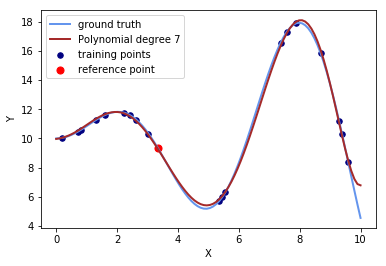

In [47]:
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")
plt.scatter(X[lime_unit], y[lime_unit], color='red',
            s=50, marker='o', label="reference point")
plt.plot(x_plot, y_plot_pol, color=colors[1], linewidth=lw,
         label="Polynomial degree %d" % degree)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='best')
plt.show()

In [11]:
import lime
import lime.lime_tabular

predict_fn_rf = lambda x: random_forest.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,
                                                   class_names=['Will Die','Will Survive'],kernel_width=5)

In [12]:
test.loc[[421]]

Survived  Pclass   Sex   Age  SibSp  Parch    Fare Embarked
421         0       3  male  21.0      0      0  7.7333        Q

In [13]:
choosen_instance = X_test.loc[[421]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [14]:
pd.DataFrame(exp.as_list())

0         1
0       Sex_female <= 0.00 -0.241021
1  0.00 < Sex_male <= 1.00 -0.233929
2             Age <= 22.00  0.119395
3       Embarked_C <= 0.00 -0.075283
4    1.50 < Pclass <= 3.00 -0.074404
5             Fare <= 7.92 -0.062359
6            SibSp <= 0.00  0.047493
7        Embarked_Q > 0.00 -0.041703
8            Parch <= 0.00 -0.019583
9       Embarked_S <= 0.00 -0.000660

In [15]:
print("LIME prediction is: \t",pd.DataFrame(exp.as_list())[1].sum())

LIME prediction is: 	 -0.5820530545778536


In [16]:
test.loc[[310]]

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
310         1       1  female  24.0      0      0  83.1583        C

In [17]:
choosen_instance = X_test.loc[[310]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [18]:
pd.DataFrame(exp.as_list())

0         1
0  0.00 < Sex_female <= 1.00  0.234981
1           Sex_male <= 0.00  0.231774
2               Fare > 31.00  0.116141
3          Embarked_C > 0.00  0.075980
4             Pclass <= 1.50  0.067187
5              SibSp <= 0.00  0.048844
6         Embarked_Q <= 0.00  0.031044
7              Parch <= 0.00 -0.022400
8       22.00 < Age <= 29.53 -0.007829
9         Embarked_S <= 0.00  0.006700

In [19]:
print("LIME prediction is: \t",pd.DataFrame(exp.as_list())[1].sum())

LIME prediction is: 	 0.7824213227276844


In [20]:
test.loc[[736]]

Survived  Pclass     Sex   Age  SibSp  Parch    Fare Embarked
736         0       3  female  48.0      1      3  34.375        S

In [21]:
choosen_instance = X_test.loc[[736]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [22]:
pd.DataFrame(exp.as_list())

0         1
0  0.00 < Sex_female <= 1.00  0.242701
1           Sex_male <= 0.00  0.230771
2                Age > 35.00 -0.115317
3               Fare > 31.00  0.113374
4      1.50 < Pclass <= 3.00 -0.077803
5         Embarked_C <= 0.00 -0.068216
6         Embarked_Q <= 0.00  0.031605
7       0.00 < SibSp <= 1.00 -0.020763
8               Parch > 0.00  0.017624
9  0.00 < Embarked_S <= 1.00 -0.010425

In [23]:
print("LIME prediction is: \t",pd.DataFrame(exp.as_list())[1].sum())

LIME prediction is: 	 0.3435523811911904


In [24]:
test.loc[[788]]

Survived  Pclass   Sex  Age  SibSp  Parch    Fare Embarked
788         1       3  male  1.0      1      2  20.575        S

In [25]:
choosen_instance = X_test.loc[[788]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [26]:
pd.DataFrame(exp.as_list())

0         1
0         Sex_female <= 0.00 -0.236930
1    0.00 < Sex_male <= 1.00 -0.233403
2               Age <= 22.00  0.125727
3         Embarked_C <= 0.00 -0.074756
4      1.50 < Pclass <= 3.00 -0.074229
5         Embarked_Q <= 0.00  0.045460
6      14.50 < Fare <= 31.00 -0.039185
7       0.00 < SibSp <= 1.00 -0.031340
8               Parch > 0.00  0.015851
9  0.00 < Embarked_S <= 1.00 -0.009220

In [27]:
print("LIME prediction is: \t",pd.DataFrame(exp.as_list())[1].sum())

LIME prediction is: 	 -0.5120235165605621


In [37]:
kernel_width=0.01
model = pol
lime_unit = 9

In [38]:
def lime_line(lime_exp,x_plot):
    x_plot_std = (x_plot-X.mean())/X.std()
    lime_plot = lime_exp.intercept[0] + lime_exp.local_exp[1][0][1]*x_plot_std
    return lime_plot

In [39]:
#Kernel Width defines Locality
kernel_width_vector = [[0.1,0.3],[0.5,0.7]]

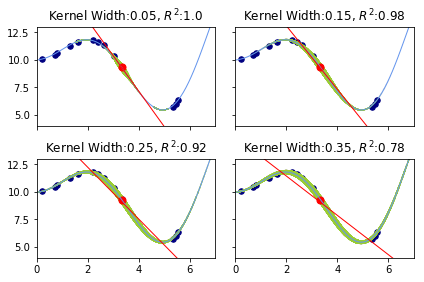

In [48]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
custom_ylim = (4,13)
custom_xlim= (0,7)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

for i,kw in enumerate(kernel_width_vector):
    for j,kernel_width in enumerate(kw):

        lime_explainer = LimeTabularExplainerOvr(X,
                                                 mode="regression",
                                                 verbose=False,
                                                 discretize_continuous=False,
                                                 kernel_width=kernel_width,
                                                 sample_around_instance=True,
                                                 penalty=0,
                                                 random_state=seed
                                                 )
        lime_exp = lime_explainer.explain_instance(X[lime_unit],model.predict)
        weights = lime_explainer.base.weights
        rescaled_weights = 20* (weights- weights.min()) /(weights.max()-weights.min())
        lime_points = pd.concat([pd.DataFrame(lime_explainer.data,columns=["X"]),pd.DataFrame(lime_explainer.lime_preds,columns=["Y"]),
                                 pd.DataFrame(rescaled_weights,columns=["weights"])],axis=1)
        lime_plot = lime_line(lime_exp,x_plot)

        ax[i, j].plot(x_plot, y_plot_pol, color="cornflowerblue", linewidth=1,
             label="ML - Polynomial degree %d" % degree)
        ax[i, j].scatter(x, y, color='navy', s=30, marker='o', label="training points")
        ax[i, j].plot(x_plot,lime_plot,label="LIME line",color="red",linewidth=1)
        ax[i, j].scatter(lime_points.X,lime_points.Y,color='yellowgreen', s=lime_points.weights, marker='o', label="LIME sampled points")
        ax[i, j].scatter(X[lime_unit],y_pol[lime_unit],color='red', s=50, marker='o')
        ax[i, j].title.set_text(r"Kernel Width:{}, $R^2$:{}".format(kernel_width,round(lime_exp.score,2)))

        
fig.tight_layout(pad=1)
plt.show()

In [49]:
#Ridge Penalty 
kernel_width_vector = [[0.05,0.15],[0.25,0.35]]
ridge_penalty_vector = [0,2]

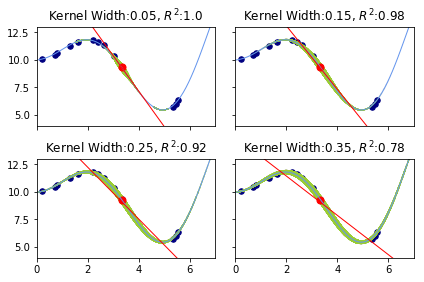

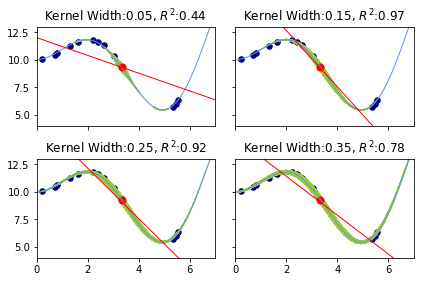

In [50]:
for ridge_penalty in ridge_penalty_vector:
    fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
    custom_ylim = (4, 13)
    custom_xlim = (0, 7)
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    for i, kw in enumerate(kernel_width_vector):
        for j, kernel_width in enumerate(kw):

            lime_explainer = LimeTabularExplainerOvr(X,
                                                     mode="regression",
                                                     verbose=False,
                                                     discretize_continuous=False,
                                                     kernel_width=kernel_width,
                                                     sample_around_instance=True,
                                                     penalty=ridge_penalty,
                                                     random_state=seed
                                                     )
            lime_exp = lime_explainer.explain_instance(
                X[lime_unit], model.predict)
            weights = lime_explainer.base.weights
            rescaled_weights = 20 * \
                (weights - weights.min()) / (weights.max()-weights.min())
            lime_points = pd.concat([pd.DataFrame(lime_explainer.data, columns=["X"]), 
                                     pd.DataFrame(lime_explainer.lime_preds, columns=["Y"]),
                                     pd.DataFrame(rescaled_weights, columns=["weights"])], axis=1)
            lime_plot = lime_line(lime_exp, x_plot)

            ax[i, j].plot(x_plot, y_plot_pol, color="cornflowerblue", linewidth=1,
                          label="ML - Polynomial degree %d" % degree)
            ax[i, j].scatter(x, y, color='navy', s=30,
                             marker='o', label="training points")
            ax[i, j].plot(x_plot, lime_plot, label="LIME line",
                          color="red", linewidth=1)
            ax[i, j].scatter(lime_points.X, lime_points.Y, color='yellowgreen',
                             s=lime_points.weights, marker='o', label="LIME sampled points")
            ax[i, j].scatter(X[lime_unit], y_pol[lime_unit],
                             color='red', s=50, marker='o')
            ax[i, j].title.set_text(r"Kernel Width:{}, $R^2$:{}".format(
                kernel_width, round(lime_exp.score, 2)))

    fig.tight_layout(pad=1)
    plt.show()